### mac gpu 사용가능확인 (1이면 사용가능)

In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import

In [5]:
# tensorflow.compat.v2 를 사용
import tensorflow.compat.v2 as tf
import pandas as pd
from matplotlib import pyplot as plt
import re
import cv2
import time

# dataset
> 각 train 데이터 ( train_1 ~ train_10) 는 small_data.ipynb 에서 따로 처리하여 만들어짐.  
> 영어만 추출, image_url 과 caption_feature 만 추출.

출처 : https://www.kaggle.com/c/wikipedia-image-caption/code?competitionId=29705&searchQuery=tensor

In [6]:
# caption_feature를 보면
# 1. [SEP] 으로 나뉘어져 있는데, 그 뒤에 있는 내용에 대해 할 것. (BERT)에서 사용하는 스페셜 토큰인데 파인튜닝은 안할 것이므로..
# 2. 숫자정보는 제외하자 대부분 특수한 경우에 쓰이거나 주소 등이다.

df = pd.read_csv('/content/drive/MyDrive/dataset/wiki/train_1.tsv', delimiter = '\t')
p = re.compile('\[SEP\].+') # \로 감싸진 곳은 
df['caption_title_and_reference_description'] = df['caption_title_and_reference_description'].apply(
                                lambda x: '<start> ' + 
                                        re.sub('\d+', '', p.search(x).group().replace('[SEP] ', '')).lower() 
                                        +' <end>'
                                        if p.search(x).group() not in['[SEP] ', ''] else None)
df=df.dropna(axis=0)
print(df.shape)
df.head()

(301484, 2)


,image_url,caption_title_and_reference_description
0,https://upload.wikimedia.org/wikipedia/commons...,<start> downtown deer park <end>
1,https://upload.wikimedia.org/wikipedia/commons...,"<start> jürgen ovens's justitia, -, museumsber..."
2,https://upload.wikimedia.org/wikipedia/commons...,<start> mv agusta raid <end>
4,https://upload.wikimedia.org/wikipedia/commons...,<start> seth macfarlane's logo <end>
6,https://upload.wikimedia.org/wikipedia/commons...,<start> erskine river at lorne <end>


In [7]:
import cv2
import numpy as np
from urllib import request

def url_to_image(url):
    '''
    url 에서 이미지를 추출하여, (512,512,3) 의 rgb ndarray로 리턴
    '''
    resp = request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype='uint8')
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)#/255.0
    return image
    #return cv2.resize(image, (512,512))

<start> figure : genomic context scheme of smrc and its closest homologues in other organisms. the αr rna genes are represented by red arrows and the flanking orfs by arrows on different colors depending on their product function (legend). numbers indicate the αr rna gene's and flanking orfs coordinates in each organism genome database. the gene strand is represented with the file direction. on the left of the figure identification names are used which correspond to a certain organism: αr_smrc = sinorhizobium meliloti  (nc_), αr_smedrc = sinorhizobium medicae wsm chromosome (nc_), αr_sfrc = sinorhizobium fredii ngr chromosome (nc_), αr_atrc = agrobacterium tumefaciens str. c chromosome linear (nc_), αr_reciatrc = rhizobium etli ciat  (nc_), αr_arrc = agrobacterium radiobacter k chromosome  (nc_), αr_rltrc = rhizobium leguminosarum bv. trifolii wsm (nc_), αr_avrc = agrobacterium vitis s chromosome  (nc_), αr_rlvrc = rhizobium leguminosarum bv. viciae  (nc_), αr_rltrc = rhizobium legumin

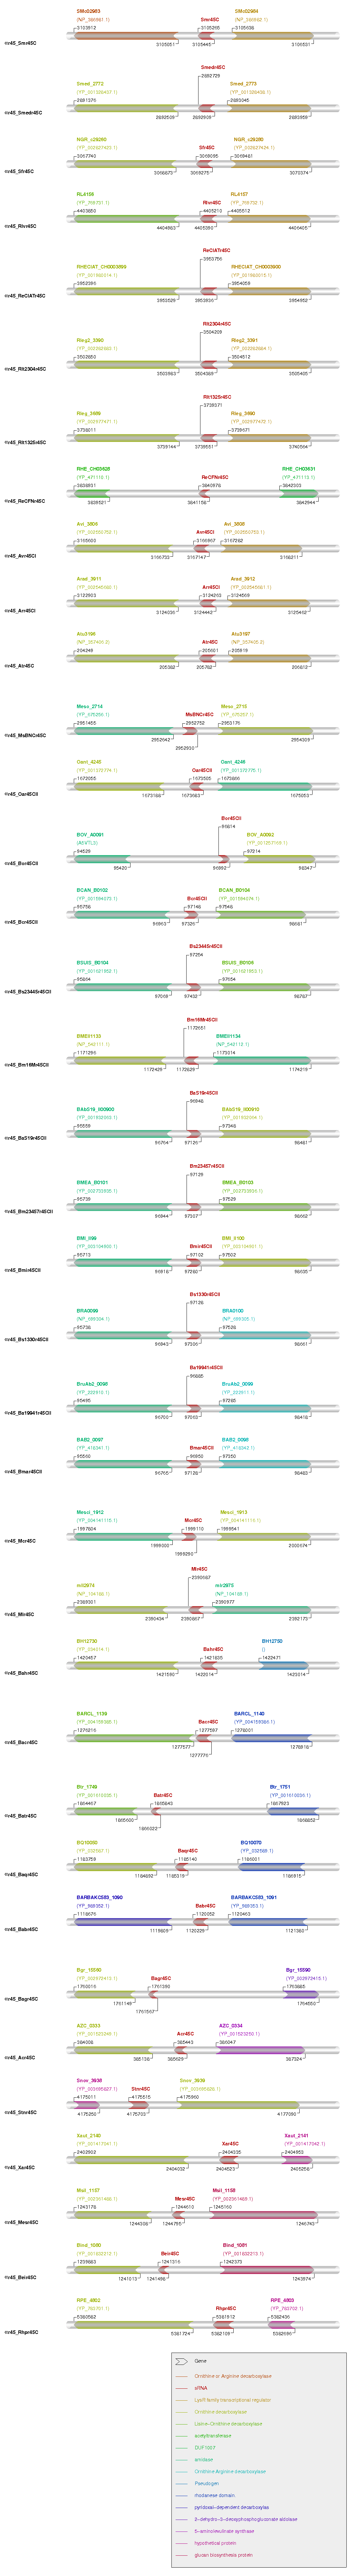

(7992, 1080, 3)
2492


In [8]:
# 가장 긴 캡션과 그의 이미지 출력해보기 (모델상에서는 실행안해도됨.)
from google.colab.patches import cv2_imshow
long_caption = max(df['caption_title_and_reference_description'], key = lambda x: len(x))
a = df[df['caption_title_and_reference_description'] == long_caption ]['image_url']
#a = df[df['caption_title_and_reference_description'] == 'Downtown Deer Park']['image_url']
x = url_to_image(str(a.iloc[0]))
print(long_caption)
cv2_imshow(x)
print(x.shape)
print(len(long_caption))

# 전처리
> 위에서 확인했듯, caption 이 제일 긴 행에 대해  
> 1. 이미지가 너무 크다(7992,1080). >  512,512 로 압축하게 되면 심각하게 찌그러 질것,
> 2. caption이 너무 길다. 3011자.

> 해결방법
> 1. caption이 너무 긴 행(100자 이상)은 삭제.  
> 2. image 파일이 너무 큰(가로 세로 비율이 2:1 혹은 1:2 를 초과) 경우는 삭제

In [9]:
# 위 url_to_image 다시 정의
def url_to_image(url):
    '''
    url 에서 이미지를 추출하여, (512,512,3) 의 rgb ndarray로 리턴
    '''
    resp = request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype='uint8')
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)#/255.0
    if type(image) == type(None):
        return np.array([None])
    image = image/255.0
    if ( image.shape[0]/image.shape[1] > 2 ) or ( image.shape[0]/image.shape[1] < 1/2 ):  # 가로세로 비율이 1:2, 2:1을 벗어난다면
        return np.array([None])
    else:
        return cv2.resize(image, (299,299))

In [10]:
X_pre_train=[]
y_train=[]
for i,j in enumerate((df.iloc[1500:2000]['image_url'])):
    try:
        temp = url_to_image(j)
    except:
        pass
    if None in temp:
        pass
    else:
        try:
          X_pre_train.append(temp)
          y_train.append( df.iloc[i]['caption_title_and_reference_description'] )
        except:
          pass
print(len(X_pre_train))
print(X_pre_train[2].shape)
print(len(y_train))
print(y_train[2])

# png 파일일 경우 libpng경고가 나오는데 무시해도 좋을듯하다.
# srv 파일의 경우 

388
(299, 299, 3)
388
<start>  mv agusta  raid <end>


In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [12]:
# imagenet 가중치를 사용하여 특성추출
BATCH_SIZE = 64
image_dataset = tf.data.Dataset.from_tensor_slices(X_pre_train)
image_dataset = image_dataset.batch(BATCH_SIZE)
np_batch_features = np.array([np.zeros((64,2048))])   # 여기서 64는 batch_size가 아니라 InceptionV3의 마지막 레이어 아웃풋 모양
for img in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for temp_img in batch_features:
      np_batch_features = np.append(np_batch_features, np.array(temp_img).reshape(1,64,2048), axis=0)

np_batch_features = np_batch_features[1:]

In [13]:
np_batch_features.shape

(388, 64, 2048)

In [14]:
# y_train 은 캡션 문장인데, 토크나이저를 통해 문장들을 단어별 벡터화 해준다. (cap_vector)

top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&*+.-;?@[]^`{}~ ')
tokenizer.fit_on_texts(y_train)
train_seqs = tokenizer.texts_to_sequences(y_train)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(y_train[3])
print(len(cap_vector))
cap_vector[3]

<start> erskine river at lorne <end>
388


array([  2, 304,  31,   9, 305,   3,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [15]:
#size_test = int( 0.01 * len(cap_vector)) 
size_test = 1       # test 는 딱 마지막에 확인용으로 사용하자.
X_test = np.array(np_batch_features)[0:size_test]
X_train = np.array(np_batch_features)[size_test:]
y_test = cap_vector[0:size_test]
y_train = cap_vector[size_test:]
len(X_test), len(y_test), len(X_train), len(y_train)

(1, 1, 387, 387)

In [36]:
X_test.shape

(1, 64, 2048)

# 전역변수

In [16]:
BUFFER_SIZE = 1000
embedding_dim = 512
units = 512
vocab_size = top_k + 1
num_steps = len(X_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

## 데이터셋 지정

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# optimizer, loss func..

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# model 정의

In [19]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    '''
    W1, W2, V 는 학습가능한 가중치벡터
    '''
    super(BahdanauAttention, self).__init__()   # 부모클래스 (tf.keras.Model.init()사용)
    self.W1 = tf.keras.layers.Dense(units)      # units(전역) 수 의 node를 갖는 W1 가중치
    self.W2 = tf.keras.layers.Dense(units)      # 위와 동 w2 가중치
    self.V = tf.keras.layers.Dense(1)           # V가중치는 하나로.

  def call(self, features, hidden):
    '''
    feautures : 이미지의 피쳐맵
    hidden : hidden state
    '''
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
    score = self.V(attention_hidden_layer)
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [20]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [21]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

# trian step 정의

In [22]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [23]:
checkpoint_path = "./drive/MyDrive/dataset/wiki/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [24]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [25]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [26]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [27]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 5 Batch 0 Loss 1.7554
Epoch 5 Loss 1.809353
Time taken for 1 epoch 157.57 sec

Epoch 6 Batch 0 Loss 1.1847
Epoch 6 Loss 1.441257
Time taken for 1 epoch 46.38 sec

Epoch 7 Batch 0 Loss 1.0604
Epoch 7 Loss 1.354600
Time taken for 1 epoch 45.60 sec

Epoch 8 Batch 0 Loss 1.2198
Epoch 8 Loss 1.334983
Time taken for 1 epoch 45.94 sec

Epoch 9 Batch 0 Loss 1.0771
Epoch 9 Loss 1.477467
Time taken for 1 epoch 46.14 sec

Epoch 10 Batch 0 Loss 1.2247
Epoch 10 Loss 1.347626
Time taken for 1 epoch 45.70 sec

Epoch 11 Batch 0 Loss 1.0726
Epoch 11 Loss 1.260275
Time taken for 1 epoch 46.71 sec

Epoch 12 Batch 0 Loss 1.2278
Epoch 12 Loss 1.200646
Time taken for 1 epoch 46.94 sec

Epoch 13 Batch 0 Loss 1.2482
Epoch 13 Loss 1.216185
Time taken for 1 epoch 46.13 sec

Epoch 14 Batch 0 Loss 1.0949
Epoch 14 Loss 1.133379
Time taken for 1 epoch 45.98 sec

Epoch 15 Batch 0 Loss 1.1599
Epoch 15 Loss 1.292254
Time taken for 1 epoch 46.25 sec

Epoch 16 Batch 0 Loss 0.9927
Epoch 16 Loss 1.213316
Time taken 

# 예측 모델

In [44]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_length = max_length = calc_max_length(y_train)

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(url_to_image(image), 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [29]:
def plot_attention(image, result, attention_plot):
    #temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        #ax = fig.add_subplot(grid_size, grid_size, i+1)
        #ax.set_title(result[i])
        #img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

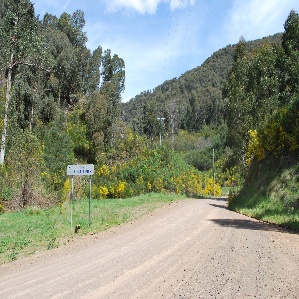

Real Caption: <start> entering a mining settlement from jamieson <end>
Prediction Caption: a np on either may river the wyndham's <end>


In [53]:
# captions on the validation set
image_url = df['image_url'][20]
real_caption = df['caption_title_and_reference_description'][20]
result, attention_plot = evaluate(image_url)

cv2_imshow(url_to_image(image_url)*255)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image_url, result, attention_plot)